# Introduction to GPT-4 Vision

This notebook illustrates how to use `gpt-4-vision-preview` model to take in images and answer questions about them. The notebook actually follows the same steps described in the official documentation at this link: [Vision](https://platform.openai.com/docs/guides/vision). Here, we take an MP4 video downloaded from YouTube, use `cv2`and `base64` to  extract image frames and pass them to the model to get back a description of the video. 

In [1]:
from openai import OpenAI

In [2]:
# import main packages
from IPython.display import display, Image, Audio

import cv2  
import base64
import time
import os
import requests
import json

In [3]:
# Read a configuration file with the api_key
conf_file = open("conf.json")
conf_json = json.load(conf_file)

In [4]:
client = OpenAI(api_key=conf_json["api_key"])

## Extracting Frames

In the following, we open the MP4 file using OpenCV and extract image frames:

In [6]:
def get_frames(video_path: str, encoding = "utf-8") -> list:
    '''
    Function to generate a list of image frames from a video opened with OpenCV

    :params video_path: the path of the mp4 video file
    :params encoding: the encoding 
    :returns: a list of image frames
    '''

    video = cv2.VideoCapture(video_path)

    base64Frames = []
    while video.isOpened():
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode(encoding))
    
    video.release()

    return base64Frames

In [10]:
my_video_path = "files/man-crying-clip.mp4"
encoding = "utf-8"

In [11]:
my_video_frames = get_frames(my_video_path, encoding=encoding)

In [12]:
print(f"The number of frames read is: {len(my_video_frames)}")

The number of frames read is: 449


Let display again image frames to look at the video processed:

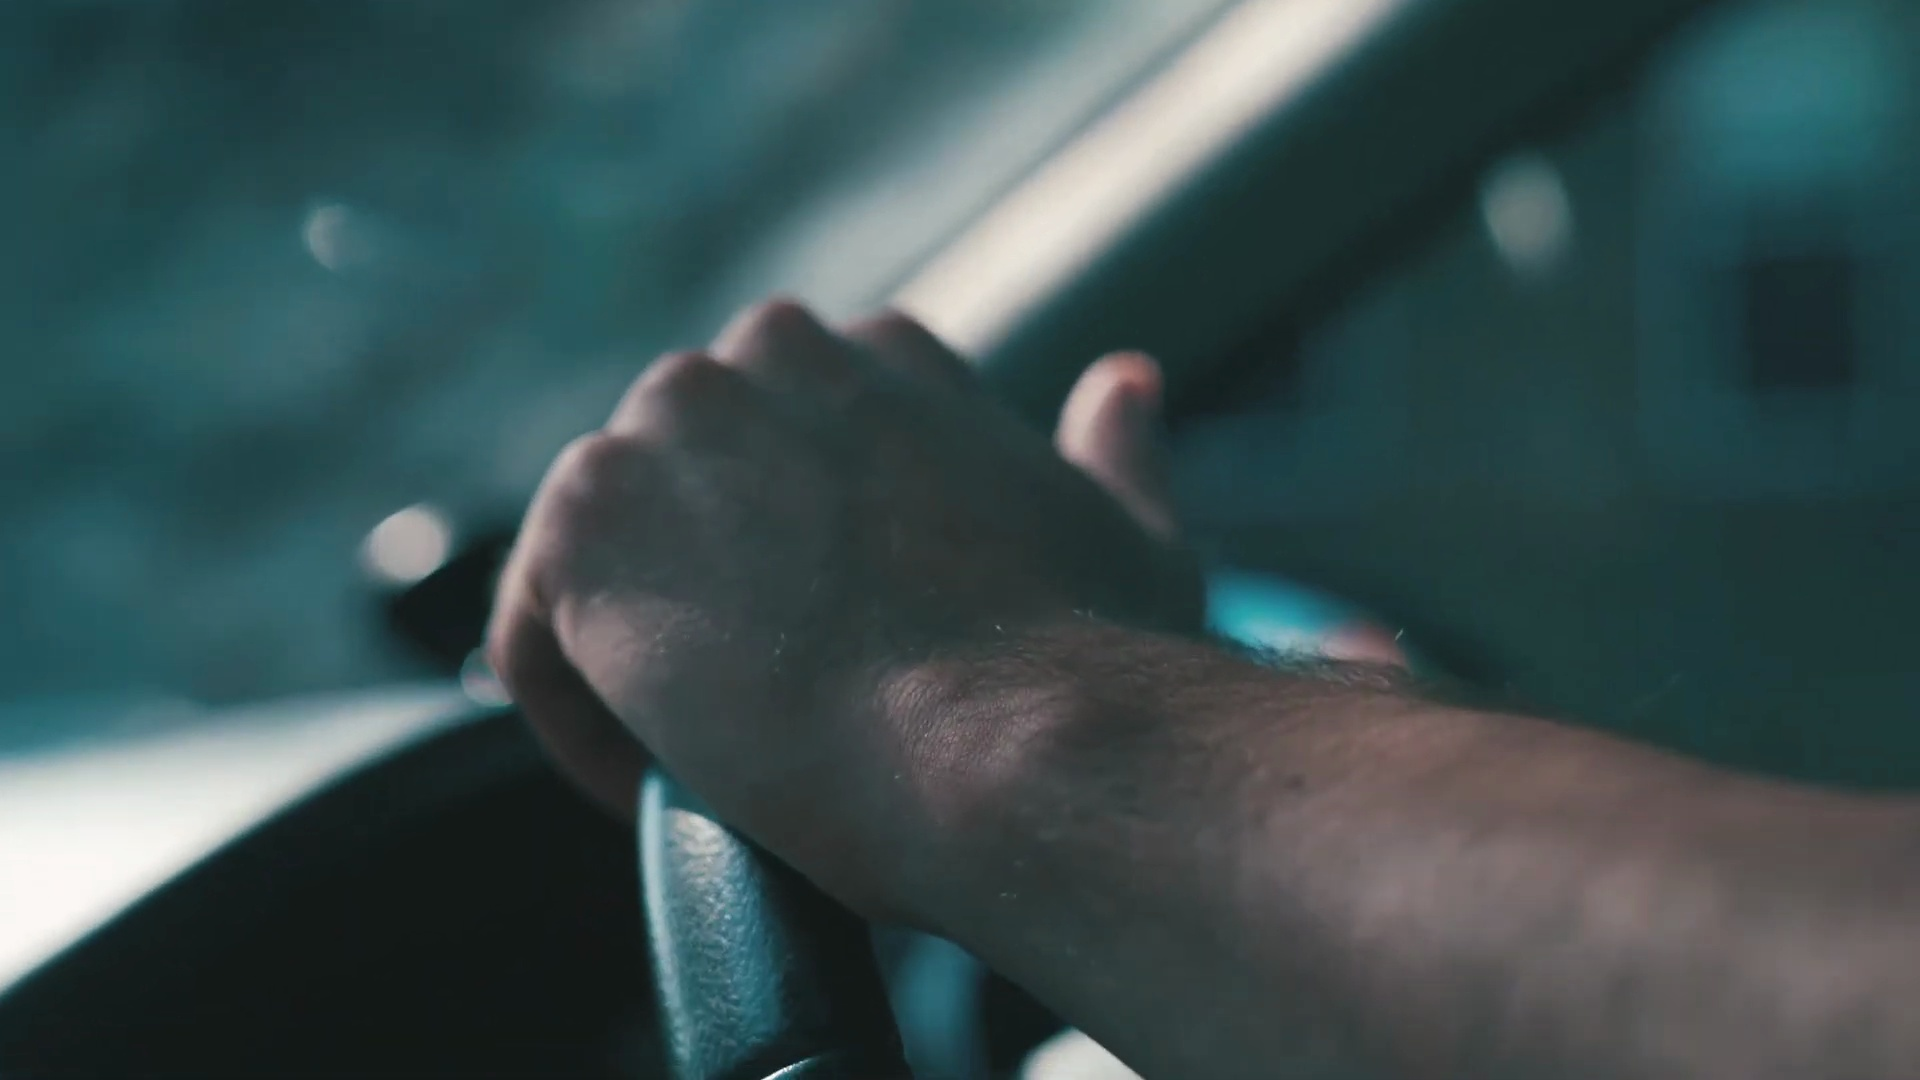

In [13]:
display_handle = display(None, display_id=True)
for img in my_video_frames:
    display_handle.update(Image(data=base64.b64decode(img.encode(encoding))))
    time.sleep(0.025)

## Use GPT-4 Vision to get Video Descriptions

We can now insert image frames inside a user prompt and ask the model for a description.

In [14]:
def get_model_response(params: dict) -> str:
    '''
    Function to get the model response:

    :params params: a dictionary with api call parameters
    :returns: the response message

    '''
    result = client.chat.completions.create(**params)

    return result.choices[0].message.content

In [16]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            """These are frames from a video that I want to upload. Generate a description of the video. Focus on the characters, the atmosphere and 
            the colors""",
            *map(lambda x: {"image": x, "resize": 768}, my_video_frames[0::50]),
        ],
    },
]

Notice that **we do not need to pass all the frames to the model to let him understand the video overall**.

In [18]:
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

In [19]:
model_response = get_model_response(params)

In [20]:
model_response

"The video appears to be a deeply emotional and introspective piece, capturing a series of close-up shots of a man expressing a range of subtle emotions. The atmosphere of the video seems somber and contemplative, evoked through the use of cool, muted colors and shadowy lighting that contribute to an overall melancholic mood.\n\nThe frames focus tightly on the man's profile, indicating that the narrative may be centered around his personal experience or emotional journey. His expressions shift from a frown and closed eyes, possibly suggesting sadness or distress, to a moment where he seems to be smiling or finding some momentary solace or relief.\n\nThe color palette consists predominately of blues and grays, with soft lighting that highlights the contours of the man's face, adding to the intimate and reflective nature of the video. The background is blurred, ensuring that attention remains on the character and his expressions, further enveloping the viewer in the man's internal world.